# =========================================================
# Setup & Imports
# =========================================================

In [3]:
import pandas as pd 
import numpy as np
import os
from helpers import *  
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")

print("✅ Environment ready – helpers imported successfully.")

✅ Environment ready – helpers imported successfully.


# =========================================================
# Data Loading & Splitting
# =========================================================

In [4]:
# Folder path where all pickle files exist
data_folder = "../DataNewPandas"

# File paths (inside the folder)
files = [
    os.path.join(data_folder, "df1_new.pkl"),
    os.path.join(data_folder, "df2_new.pkl"),
    os.path.join(data_folder, "df3_new.pkl"),
    os.path.join(data_folder, "df4_new.pkl"),
    os.path.join(data_folder, "df5_new.pkl")
]

# 👉 We'll use first 4 for training, last one for testing
train_files = files[:4]
test_files  = files[4:]

# Load and average training data
df_train = load_and_merge_training_data(train_files)

# Load test file (for unseen evaluation)
df_test_raw = pd.read_pickle(test_files[0])
df_test_raw = standardize_dataframe_columns(df_test_raw)

print(f"\n✅ Training data shape: {df_train.shape}")
print(f"✅ External test data shape: {df_test_raw.shape}")

✅ Loaded ../DataNewPandas\df1_new.pkl: (471519, 22)
✅ Loaded ../DataNewPandas\df2_new.pkl: (491430, 22)
✅ Loaded ../DataNewPandas\df3_new.pkl: (452282, 22)
✅ Loaded ../DataNewPandas\df4_new.pkl: (407585, 22)

✅ Merged 4 files → Final shape: (516872, 23)

✅ Training data shape: (516872, 23)
✅ External test data shape: (528097, 23)


In [5]:
# 🔧 Rename target column if needed (one-liners)
df_train.rename(columns={"Control-PPC - Active power (1m)": "active_power"}, inplace=True)
df_test_raw.rename(columns={"Control-PPC - Active power (1m)": "active_power"}, inplace=True)

print(f"✅ External test data shape: {df_test_raw.shape}")

if "Time" in df_test_raw.columns:
    df_test_raw = df_test_raw.rename(columns={"Time": "timestamp"})

✅ External test data shape: (528097, 23)


In [6]:
print(df_test_raw.columns.tolist())

['timestamp', 'Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)', 'Ambient Temp. (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Module Surface Temperature2 (degree centigrade)', 'Wind Speed (m/s)', 'Wind direction (degree)', 'Daily rain (mm)', 'Relative Humidity (%)', 'Soiling Loss Index Isc (%)', 'Soiling Loss Index Geff (%)', 'Isc Test (Amp)', 'Isc Ref (Amp)', 'Temperature Test (Deg C)', 'Temperature Reference Cell (Deg C)', 'Geff Test (W/m2)', 'Geff Reference (W/m2)', 'active_power']


# =========================================================
# Data Cleaning
# =========================================================

In [7]:
# =========================================================
# 🌞 PHYSICAL LIMITS for Solar Dataset
# =========================================================
SOLAR_PHYS_LIMITS = {
    # ☀️ Instantaneous Irradiance (W/m²)
    "Geff Reference (W/m2)": (0, 1400),
    "Geff Test (W/m2)": (0, 1400),
    "Total Solar Irradiance on Horizontal Plane GHI (W/m2)": (0, 1400),
    "Total Solar Irradiance on Inclined Plane POA1 (W/m2)": (0, 1400),
    "Total Solar Irradiance on Inclined Plane POA2 (W/m2)": (0, 1400),

    # 🔆 Cumulative Energy (Wh/m²)
    "Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)": (0, 8000),
    "Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)": (0, 8000),
    "Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)": (0, 8000),

    # 🌡️ Temperatures 
    "Ambient Temp. (degree centigrade)": (-10, 60),
    "Temperature Test (Deg C)": (-20, 90),
    "Temperature Reference Cell (Deg C)": (-20, 90),
    "Module Surface Temperature1 (degree centigrade)": (-20, 90),
    "Module Surface Temperature2 (degree centigrade)": (-20, 90),

    # 💨 Wind 
    "Wind Speed (m/s)": (0, 30),
    "Wind direction (degree)": (0, 360),

    # 💧 Humidity / Rain
    "Relative Humidity (%)": (0, 100),
    "Daily rain (mm)": (0, 200),

    # ⚙️ Electrical / Soiling
    "Isc Ref (Amp)": (0, 20),
    "Isc Test (Amp)": (0, 20),
    "Soiling Loss Index Geff (%)": (0, 100),
    "Soiling Loss Index Isc (%)": (0, 100),
}

# =========================================================
# 🧹 DATA CLEANING PIPELINE (✅ FIXED - No bfill!)
# =========================================================
print("\n🧼 Cleaning training data ")
df_train_clean = clean_dataset(
    df_train,
    phys_limits=SOLAR_PHYS_LIMITS,
    mode="train",
    fix_negatives=True
)

print("\n🧼 Cleaning test data...")
df_test_clean = clean_dataset(
    df_test_raw,
    phys_limits=SOLAR_PHYS_LIMITS,
    mode="test",
    fix_negatives=True
)

print(f"\n✅ Train shape: {df_train_clean.shape}")
print(f"✅ Test shape:  {df_test_clean.shape}")


🧼 Cleaning training data 

✅ [TRAIN] Cleaning Summary :
   • negatives_fixed: 256,559
   • invalid_timestamps_removed: 0
   • suspicious_daytime_zeros: 14,672
   • phys_clipped → Geff Reference (W/m2): 60,831 values clipped
   • phys_clipped → Geff Test (W/m2): 91,531 values clipped
   • phys_clipped → Total Solar Irradiance on Horizontal Plane GHI (Wh/m2): 21,511 values clipped
   • phys_clipped → Total Solar Irradiance on Inclined Plane POA1 (Wh/m2): 97,364 values clipped
   • phys_clipped → Total Solar Irradiance on Inclined Plane POA2 (Wh/m2): 97,274 values clipped
   • phys_clipped → Isc Ref (Amp): 47,389 values clipped
   • phys_clipped → Isc Test (Amp): 79,461 values clipped
   • phys_clipped → Soiling Loss Index Geff (%): 103,036 values clipped
   • phys_clipped → Soiling Loss Index Isc (%): 63,629 values clipped
   • nans_before: 0
   • remaining_nans: 0
   • nans_fixed: 14,672
   • nans_introduced: 0
✅ Final shape: 516,872 rows × 24 cols.


🧼 Cleaning test data...

✅ [TEST] 

# =========================================================
# Smart EDA (Redundancy Removal)
# =========================================================

In [8]:
df_train_smart, dropped_cols = drop_high_target_corr_features(
    df_train_clean, 
    target="active_power", 
    corr_thresh=0.95
)

df_test_smart = df_test_clean[df_train_smart.columns.intersection(df_test_clean.columns)]

print(f"✅ After redundancy removal → Train shape: {df_train_smart.shape}")
print(f"🗑️ Dropped columns: {dropped_cols}")

⚠️ Found 5 features with |corr| > 0.95 to target:
 - Total Solar Irradiance on Inclined Plane POA1 (W/m2): corr=0.9905
 - Total Solar Irradiance on Inclined Plane POA2 (W/m2): corr=0.9898
 - Isc Test (Amp): corr=0.9892
 - Isc Ref (Amp): corr=0.9889
 - Total Solar Irradiance on Horizontal Plane GHI (W/m2): corr=0.9549
✅ After redundancy removal → Train shape: (516872, 19)
🗑️ Dropped columns: ['Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (W/m2)', 'Isc Test (Amp)', 'Isc Ref (Amp)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)']


In [9]:
drop_cols = [
    "Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)",
    "Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)",
    "Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)"
]

df_train_filtered = df_train_smart.drop(columns=drop_cols, errors="ignore")
df_test_filtered  = df_test_smart.drop(columns=drop_cols, errors="ignore")

print("✅ Columns after filtering:")
print(df_train_filtered.columns.tolist())

✅ Columns after filtering:
['timestamp', 'Ambient Temp. (degree centigrade)', 'active_power', 'Daily rain (mm)', 'Geff Reference (W/m2)', 'Geff Test (W/m2)', 'Module Surface Temperature1 (degree centigrade)', 'Module Surface Temperature2 (degree centigrade)', 'Relative Humidity (%)', 'Soiling Loss Index Geff (%)', 'Soiling Loss Index Isc (%)', 'Temperature Reference Cell (Deg C)', 'Temperature Test (Deg C)', 'Wind Speed (m/s)', 'Wind direction (degree)', 'hour']


In [10]:
df_test_filtered.to_pickle("test_data.pkl")
print("✅ saved successfully")

✅ saved successfully


# =========================================================
# Feature Selection (PCC, MI, Spearman, Jaccard)
# =========================================================

In [11]:
top_pcc, top_mi, rho, jaccard = select_features(
    df_train_filtered, 
    target="active_power", 
    top_k=10
)

print("\n🔹 Top features (PCC):", top_pcc)
print("🔹 Top features (MI):", top_mi)

📊 Spearman correlation (PCC vs MI ranks): 0.582
🧩 Jaccard similarity (top-10): 0.538

🔹 Top features (PCC): ['Geff Test (W/m2)', 'Geff Reference (W/m2)', 'Module Surface Temperature2 (degree centigrade)', 'Temperature Reference Cell (Deg C)', 'Module Surface Temperature1 (degree centigrade)', 'Temperature Test (Deg C)', 'Ambient Temp. (degree centigrade)', 'Wind Speed (m/s)', 'Relative Humidity (%)', 'Wind direction (degree)']
🔹 Top features (MI): ['Geff Reference (W/m2)', 'Geff Test (W/m2)', 'hour', 'Module Surface Temperature2 (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Temperature Reference Cell (Deg C)', 'Temperature Test (Deg C)', 'Soiling Loss Index Isc (%)', 'Soiling Loss Index Geff (%)', 'Ambient Temp. (degree centigrade)']


# =========================================================
# Dataset Preparation for Modeling
# =========================================================

In [12]:
# Using top MI features (based on your original approach)
df_mi = df_train_filtered[top_mi + ["active_power"]].copy()

# Use Saudi Arabia season definition
if "timestamp" in df_train_filtered.columns:
    df_mi["timestamp"] = pd.to_datetime(df_train_filtered["timestamp"], errors="coerce")
else:
    df_mi["timestamp"] = pd.Timestamp.now()

df_mi["month"] = df_mi["timestamp"].dt.month
df_mi["season"] = df_mi["month"].apply(get_saudi_season)  

# Split features / target / groups
X = df_mi.drop(columns=["active_power", "timestamp", "season"])
y = df_mi["active_power"]
groups = df_mi["season"]

print(f"✅ Final modeling dataset shape: {X.shape}")

✅ Final modeling dataset shape: (516872, 11)


In [13]:
print(X.columns.tolist())

['Geff Reference (W/m2)', 'Geff Test (W/m2)', 'hour', 'Module Surface Temperature2 (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Temperature Reference Cell (Deg C)', 'Temperature Test (Deg C)', 'Soiling Loss Index Isc (%)', 'Soiling Loss Index Geff (%)', 'Ambient Temp. (degree centigrade)', 'month']


# =========================================================
#  Models & Parameters
# =========================================================

In [14]:
models_with_params = {
    "Poly1": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(1, include_bias=False)),
            ("ridge", Ridge())
        ]),
        {"ridge__alpha": [0.1, 1.0, 10.0]}
    ),
    "Poly2": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(2, include_bias=False, interaction_only=True)),
            ("ridge", Ridge(max_iter=5000))
        ]),
        {"ridge__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]}
    ),
    "XGBoost": (
        XGBStable(
            random_state=42,
            n_jobs=-1,
            eval_metric="rmse"
        ),
        {
            "n_estimators": [500,],             
            "max_depth": [4],                    
            "learning_rate": [0.03],          
            "min_child_weight": [5],        
            "reg_lambda": [2.0, ],       
            "reg_alpha": [ 1.0],                
            "subsample": [0.8],                     
            "colsample_bytree": [0.8],               
            "gamma": [0.1] 
        }
    )
}


🚀 Running GridSearchCV (TimeSeriesSplit=5) for Poly1 ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best params for Poly1: {'ridge__alpha': 0.1}
🏆 Best CV RMSE: 35721.8725

🚀 Running GridSearchCV (TimeSeriesSplit=5) for Poly2 ...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ Best params for Poly2: {'ridge__alpha': 0.1}
🏆 Best CV RMSE: 44160.5921

🚀 Running GridSearchCV (TimeSeriesSplit=5) for XGBoost ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
✅ Best params for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8}
🏆 Best CV RMSE: 20376.0054

📊 Poly1 – Fold Results:
     Fold    Train_RMSE  Train_R2     Test_RMSE   Test_R2
0  Fold-1  27065.633844  0.946194  48017.272085  0.872874
1  Fold-2  32333.845045  0.935365  34138.956161  0.939523
2  Fold-3  32055.380390  0.941146  23262.127064  0.968500
3  Fold-

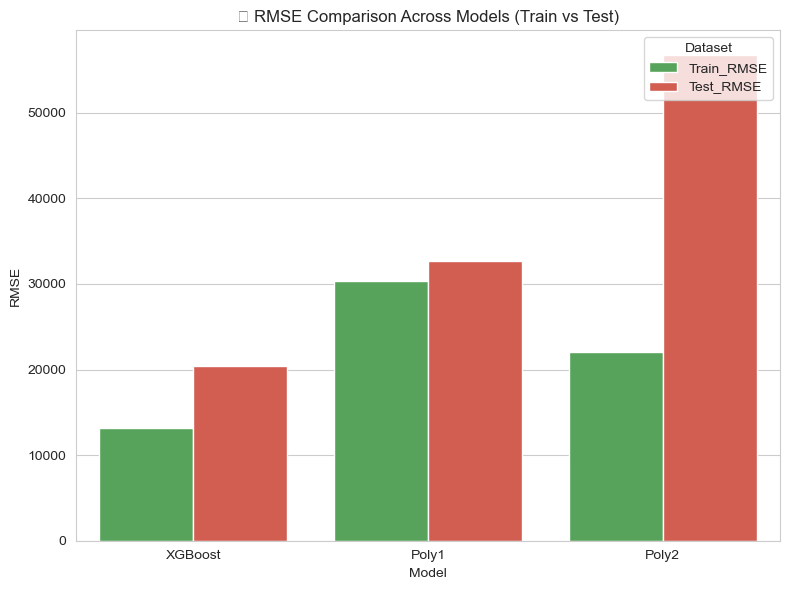


📊 Feature Importance for best Poly1 model:


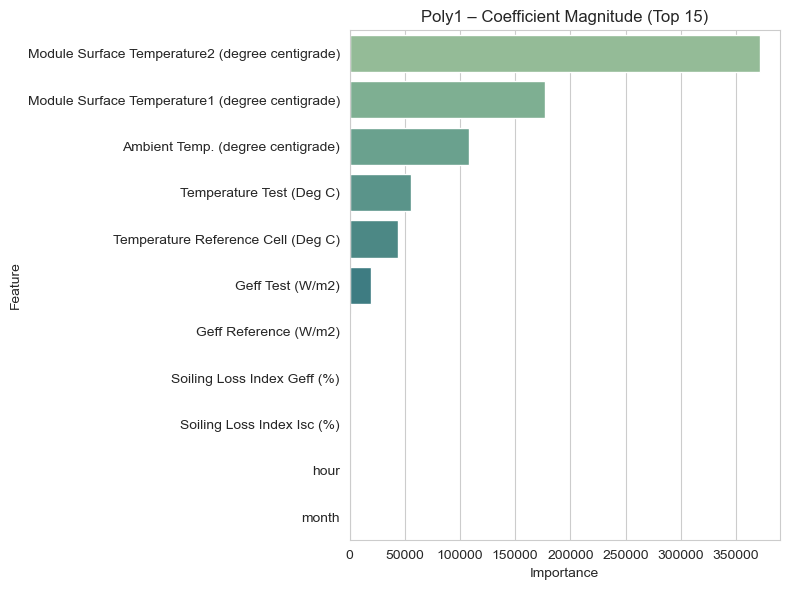


📊 Feature Importance for best Poly2 model:


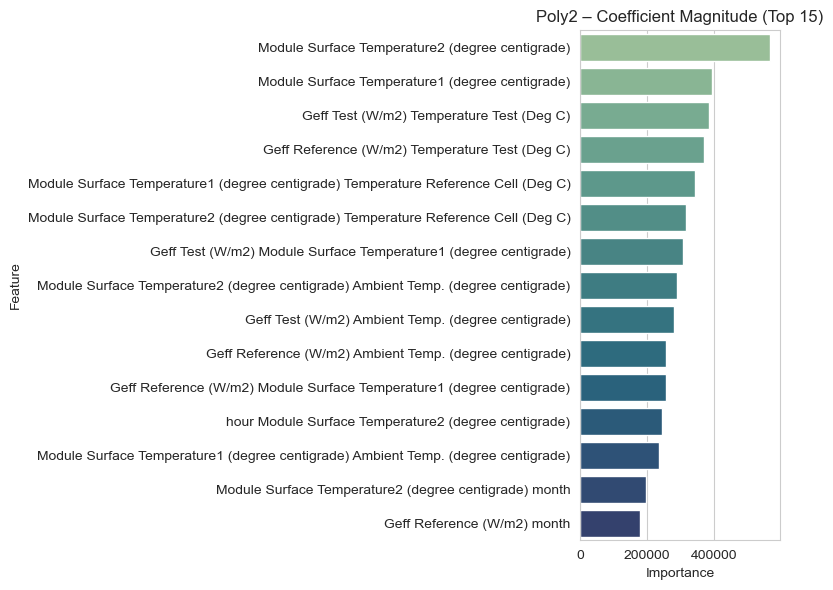


📊 Feature Importance for best XGBoost model:


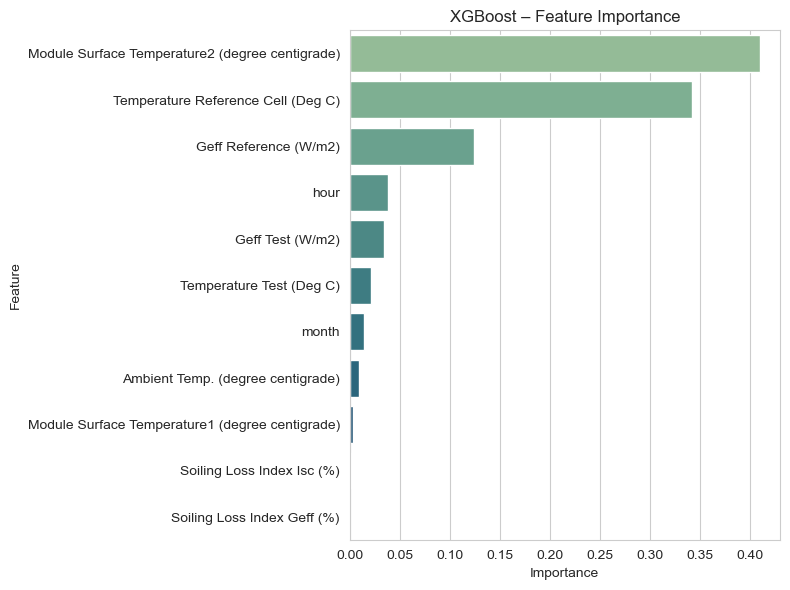

In [15]:
grids = run_multiple_timeSeries_gridsearches(models_with_params, X, y)
labels = ["Fold-1", "Fold-2", "Fold-3", "Fold-4"]

evals = {
    name: evaluate_best_model(grid, X, y, groups, name, group_labels=labels)
    for name, grid in grids.items()
}

summary = compare_models_results(evals)

import matplotlib.pyplot as plt
import seaborn as sns

for model_name, grid in grids.items():
    best_model = grid.best_estimator_
    print(f"\n📊 Feature Importance for best {model_name} model:")

    if hasattr(best_model, "feature_importances_"):
        plot_feature_importance(best_model, X, title=f"{model_name} – Feature Importance")

    elif "ridge" in [step for step, _ in best_model.named_steps.items()]:
        ridge = best_model.named_steps["ridge"]
        poly = best_model.named_steps.get("poly", None)

        if poly is not None:
            feature_names = poly.get_feature_names_out(X.columns)
        else:
            feature_names = X.columns

        coef = ridge.coef_.flatten()
        imp_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": np.abs(coef)
        }).sort_values("Importance", ascending=False).head(15)

        plt.figure(figsize=(8,6))
        sns.barplot(data=imp_df, x="Importance", y="Feature", palette="crest")
        plt.title(f"{model_name} – Coefficient Magnitude (Top 15)")
        plt.tight_layout()
        plt.show()

    else:
        print(f"⚠️ No feature importance available for {model_name}.")


# =========================================================
# 🌤️ REALISTIC LEAVE-ONE-SEASON-OUT EVALUATION for All Models
# =========================================================

In [16]:
seasonal_realistic_reports = {}

for model_name, grid in grids.items():
    print(f"\n{'='*60}")
    season_report = evaluate_leave_one_season_out_FIXED(
        grid, X, y, 
        season_series=groups,
        name=model_name
    )
    seasonal_realistic_reports[model_name] = season_report

combined = pd.concat(
    [df.assign(Model=name) for name, df in seasonal_realistic_reports.items()],
    ignore_index=True
)

print("\n📈 Overall Best Model per Season:")
for season in combined['Season'].unique():
    best = combined[combined['Season'] == season].nsmallest(1, 'Test_RMSE_%')
    print(f"  {season}: {best['Model'].values[0]} ({best['Test_RMSE_%'].values[0]:.1f}%)")



######## LEAVE-ONE-SEASON-OUT (Test-Focused) for Poly1 ########
   Season     Test_RMSE  Test_RMSE_%   Test_R2      Test_MAE
1  SPRING  53272.479159    46.520337  0.840649  34163.880503
0  WINTER  33303.786193    43.475143  0.907275  25240.070076
3    FALL  22675.036741    24.068350  0.964095  16930.574120
2  SUMMER  30084.622275    22.586301  0.953153  20728.595917


######## LEAVE-ONE-SEASON-OUT (Test-Focused) for Poly2 ########
   Season     Test_RMSE  Test_RMSE_%   Test_R2      Test_MAE
1  SPRING  54429.320228    47.530552  0.833653  30424.617199
0  WINTER  30015.506534    39.182585  0.924681  19123.668444
3    FALL  11846.496315    12.574428  0.990200   7181.006536
2  SUMMER  16415.055277    12.323750  0.986053  10133.457804


######## LEAVE-ONE-SEASON-OUT (Test-Focused) for XGBoost ########
   Season     Test_RMSE  Test_RMSE_%   Test_R2      Test_MAE
1  SPRING  37624.447878    32.855651  0.920514  20742.289941
0  WINTER  21021.604681    27.441843  0.963056   8318.003855
3    FA

💾 Model saved → final_xgb_model_V2.pkl


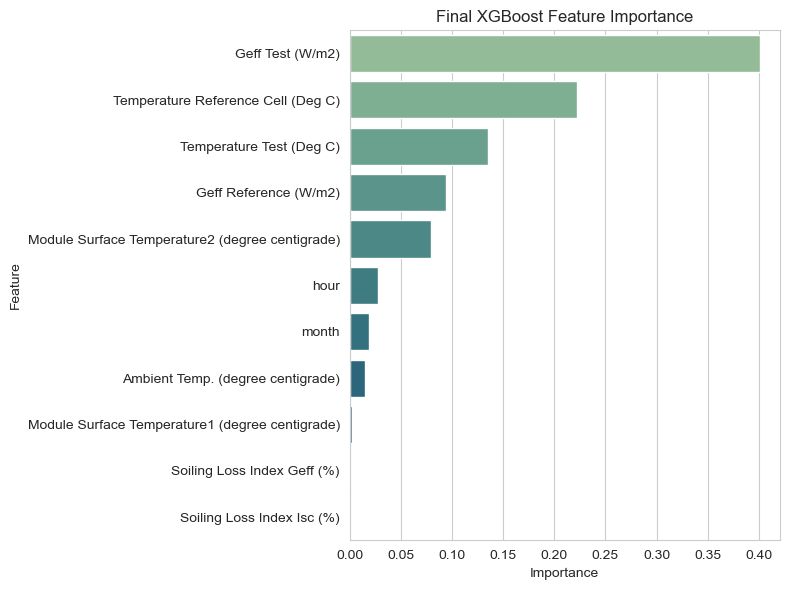

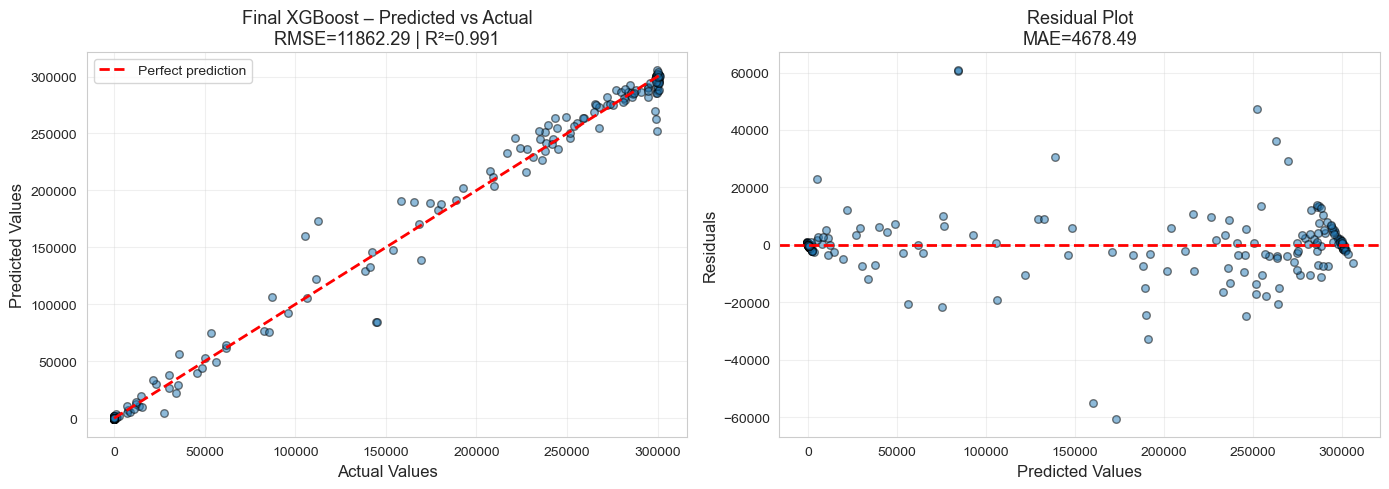


📊 Final XGBoost – Predicted vs Actual Metrics:
   RMSE: 11862.2907
   MAE : 4678.4876
   R²  : 0.9914
({'RMSE': 11862.29069867014, 'MAE': 4678.487567367217, 'R2': 0.9913777906193189},         Actual   Predicted    Residual
0          0.0 -145.604126  145.604126
1          0.0 -145.604126  145.604126
2          0.0 -145.604126  145.604126
3          0.0 -145.604126  145.604126
4          0.0 -145.604126  145.604126
...        ...         ...         ...
516867     0.0  -19.001228   19.001228
516868     0.0  -19.001228   19.001228
516869     0.0  -19.001228   19.001228
516870     0.0  -19.001228   19.001228
516871     0.0  -19.001228   19.001228

[516872 rows x 3 columns])


In [17]:
# =========================================================
# ✅ Final XGBoost Model (no separate training step)
# =========================================================
final_xgb = grids["XGBoost"].best_estimator_
save_model(final_xgb, "final_xgb_model_V2.pkl")

plot_feature_importance(final_xgb, X, "Final XGBoost Feature Importance")

# Training Performance
metrics = plot_predictions_vs_actual(
    final_xgb, 
    X, 
    y, 
    "Final XGBoost – Predicted vs Actual", 
    sample_size=300
)
print(metrics)

📦 External Test RMSE: 18,362.86
📈 External Test R²: 0.9794


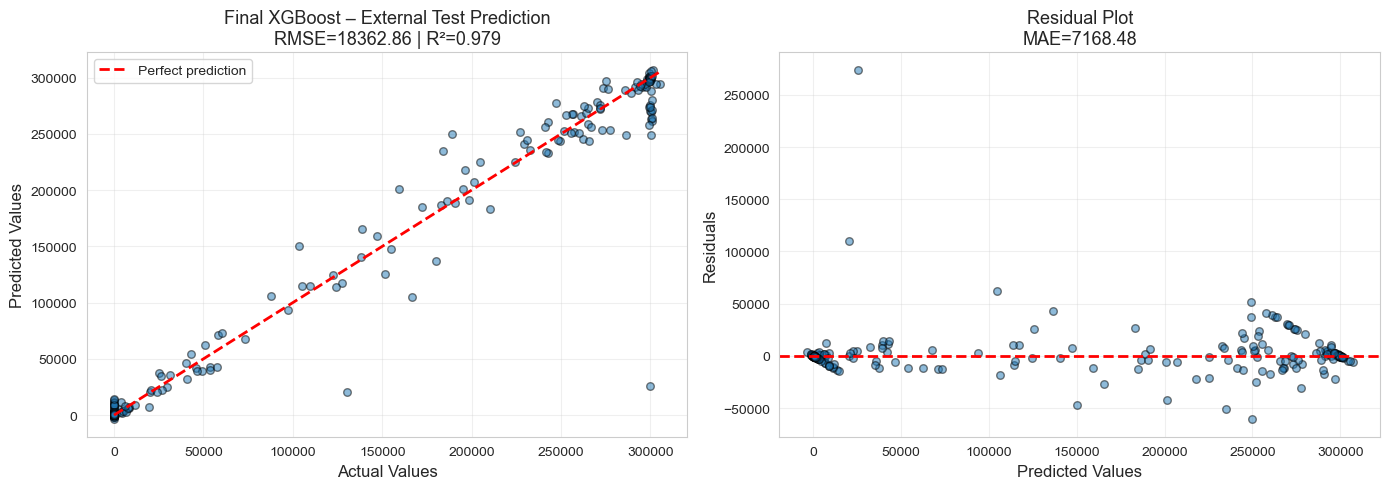


📊 Final XGBoost – External Test Prediction Metrics:
   RMSE: 18362.8553
   MAE : 7168.4751
   R²  : 0.9794

📊 Test Performance Metrics:
({'RMSE': 18362.855331421557, 'MAE': 7168.475116035342, 'R2': 0.9793543656184261},         Actual   Predicted    Residual
0          0.0 -887.191345  887.191345
1          0.0 -887.191345  887.191345
2          0.0 -887.191345  887.191345
3          0.0 -887.191345  887.191345
4          0.0 -887.191345  887.191345
...        ...         ...         ...
528092     0.0  -19.001228   19.001228
528093     0.0  -19.001228   19.001228
528094     0.0  -19.001228   19.001228
528095     0.0  -19.001228   19.001228
528096     0.0  -19.001228   19.001228

[528097 rows x 3 columns])


In [18]:
# =========================================================
# 🧪 Prepare external test data
# =========================================================
df_test_ready = df_test_filtered.copy()

# ✅ FIXED: Only forward fill (no bfill!)
df_test_ready = df_test_ready.fillna(method="ffill")

# Add month (to match training features)
df_test_ready["timestamp"] = pd.to_datetime(df_test_ready["timestamp"], errors="coerce")
df_test_ready["month"] = df_test_ready["timestamp"].dt.month

# Match columns
X_test = df_test_ready[X.columns.intersection(df_test_ready.columns)].copy()
y_test = df_test_ready["active_power"]

# Predict
y_pred = final_xgb.predict(X_test)

# Evaluate
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print(f"📦 External Test RMSE: {rmse_test:,.2f}")
print(f"📈 External Test R²: {r2_test:.4f}")

# Test Performance Visualization
metrics_test = plot_predictions_vs_actual(
    final_xgb, 
    X_test, 
    y_test, 
    title="Final XGBoost – External Test Prediction", 
    sample_size=300
)

print("\n📊 Test Performance Metrics:")
print(metrics_test)

# ==============================================
#  Inline version of evaluate_rmse_against_capacity
# ==============================================

In [ ]:
def evaluate_rmse_against_capacity(df, rmse_value, irradiance_col="Geff Reference (W/m2)", power_col="active_power"):
    """
    Estimate system capacity based on daytime irradiance and evaluate RMSE as % of capacity.
    This is a standalone inline version (no need for helpers.py).
    """

    # Ensure needed columns exist
    if irradiance_col not in df.columns or power_col not in df.columns:
        raise ValueError(f"❌ Missing required columns: {irradiance_col} or {power_col}")

    # Filter for clear-sky / daytime samples
    df_day = df[df[irradiance_col] > 200].copy()  # keep points when sun is shining

    if df_day.empty:
        raise ValueError("❌ No valid daytime data found (irradiance > 200).")

    # Estimate approximate system capacity from top 1% of measured power
    capacity_est = df_day[power_col].quantile(0.99)

    # Compute RMSE percentage relative to estimated capacity
    rmse_percent = (rmse_value / capacity_est) * 100 if capacity_est > 0 else np.nan

    # Display summary
    print(f"Estimated system capacity: {capacity_est:.1f} W")
    print(f"RMSE: {rmse_value:.2f} W  →  {rmse_percent:.2f}% of capacity")

    return {
        "capacity_est": capacity_est,
        "rmse_percent": rmse_percent
    }

In [20]:
irr_col = "Geff Reference (W/m2)"

cap_results_test = evaluate_rmse_against_capacity(
    df_test_ready,
    rmse_test,
    irradiance_col=irr_col
)

print("\n🏁 Final Model Evaluation:")
print(f"System capacity estimate: {cap_results_test['capacity_est']:.0f} W")
print(f"External Test RMSE: {rmse_test:.2f} W")
print(f"External Test RMSE% of capacity: {cap_results_test['rmse_percent']:.2f}%")
print(f"External Test R²: {r2_test:.4f}")

Estimated system capacity: 301504.9 W
RMSE: 18362.86 W  →  6.09% of capacity

🏁 Final Model Evaluation:
System capacity estimate: 301505 W
External Test RMSE: 18362.86 W
External Test RMSE% of capacity: 6.09%
External Test R²: 0.9794
